### DQN - Cart Pole

#### Environment Details

Enviornment ref doc :- [docs](https://www.gymlibrary.dev/environments/classic_control/cart_pole/)

**Description**
This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson in “[Neuronlike Adaptive Elements That Can Solve Difficult Learning Control Problem](https://ieeexplore.ieee.org/document/6313077)". A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.

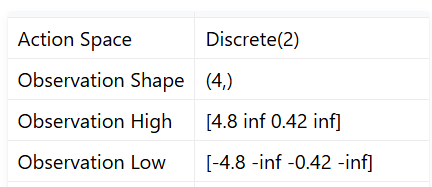


**Action Space**
The action is a ndarray with shape (1,) which can take values {0, 1} indicating the direction of the fixed force the cart is pushed with.

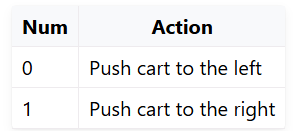

**Note:** The velocity that is reduced or increased by the applied force is not fixed and it depends on the angle the pole is pointing. The center of gravity of the pole varies the amount of energy needed to move the cart underneath it

**Observation Space**
The observation is a ndarray with shape (4,) with the values corresponding to the following positions and velocities:

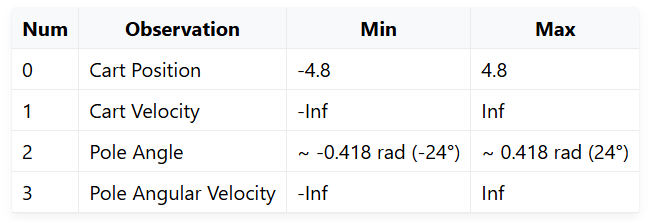

**Note:** While the ranges above denote the possible values for observation space of each element, it is not reflective of the allowed values of the state space in an unterminated episode. Particularly:

The cart x-position (index 0) can be take values between (-4.8, 4.8), but the episode terminates if the cart leaves the (-2.4, 2.4) range.

The pole angle can be observed between (-.418, .418) radians (or ±24°), but the episode terminates if the pole angle is not in the range (-.2095, .2095) (or ±12°)

**Rewards**

Since the goal is to keep the pole upright for as long as possible, a reward of +1 for every step taken, including the termination step, is allotted. The threshold for rewards is 475 for v1.

**Episode End**

The episode ends if any one of the following occurs:

* Termination: Pole Angle is greater than ±12°

* Termination: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)

* Truncation: Episode length is greater than 500 (200 for v0)

#### **Deep Q-Network (DQN) Mathematical Foundations**

#####  1. Bellman Optimality Equation

The Deep Q-Network (DQN) algorithm is based on the **Bellman Optimality Equation**, which describes the relationship between the optimal Q-value of a state-action pair and the expected sum of rewards:

$$
Q^*(s, a) = \mathbb{E} \left[ r + γ \max_{a'} Q^*(s', a') \, \middle| \, s, a \right]
$$

Where:
- \( Q*(s, a) \): The optimal Q-value for taking action \( a \) in state \( s \),
- \( r \): The immediate reward,
- \( γ in [0, 1) \): The discount factor for future rewards,
- \( s' \): The next state after taking action \( a \),
- \( a' \): All possible actions in the next state \( s' \).



##### 2. Target Q-value Computation

For a given transition \( (s, a, r, s') \), the target Q-value is computed as:

$$
y =
\begin{cases}
r, & \text{if terminal} \\
r + γ \max_{a'} Q(s', a'; θ-), & \text{otherwise}
\end{cases}
$$

Where:
- \( Q(s', a'; \θ-) \): The Q-value for the next state \( s' \), computed using the **target network** (a frozen copy of the main network).



##### 3. Loss Function

The loss function measures the difference between the predicted Q-values and the target Q-values. It is defined as:

$$
L(θ) = \frac{1}{N} \sum_{i=1}^N \left( y_i - Q(s_i, a_i; θ) \right)^2
$$

Where:
- \( θ \): The weights of the main network,
- \( N \): The mini-batch size,
- \( y_i \): The target Q-value for the \( i \)-th transition,
- \( Q(s_i, a_i; θ) \): The predicted Q-value for the \( i \)-th state-action pair.



##### 4. Policy

The agent's policy $( \pi(s) )$ selects the action that maximizes the predicted Q-value:

$$
\pi(s) = \arg\max_a Q(s, a; θ)
$$

To balance **exploration** and **exploitation**, DQN uses an epsilon-greedy strategy:
- With probability $( \epsilon )$, the agent selects a random action (exploration),
- Otherwise, it selects $( \arg\max_a Q(s, a; θ) )$ (exploitation).



##### 5. Discounted Cumulative Reward

The total discounted reward at time \( t \), denoted \( G_t \), is given by:

$$
G_t = \sum_{k=0}^\infty γ^k r_{t+k+1}
$$

Where:
- \( r_{t+k+1} \): The reward received \( k \)-steps into the future,
- \( γ ): The discount factor, which determines the importance of future rewards.

---

##### 6. Key Concepts in DQN Training

1. **Experience Replay**:
   - The agent stores transitions \( (s, a, r, s') \) in a replay buffer.
   - Mini-batches are sampled from this buffer during training to reduce correlation and improve stability.

2. **Target Network**:
   - A separate network \( Q(s, a; θ-) \) computes the target Q-values.
   - The target network's weights are updated periodically to stabilize training.

3. **Epsilon Decay**:
   - Exploration rate $( \epsilon )$ starts high (e.g., 1.0) and decays gradually to a minimum value $( \epsilon_{\text{min}} )$.

4. **Optimization**:
   - The neural network weights $( θ )$ are updated using gradient descent to minimize the loss function $( L(θ) )$.

---


In [ ]:
# drive mounting for reading in and writing out the Model
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
input_dir = '/content/drive/MyDrive'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Importing libraries
import gym
import random
import numpy as np
import pandas as pd
from collections import deque
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import os
import matplotlib.pyplot as plt
tf.keras.utils.disable_interactive_logging()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Hyperparameters
gamma =  0.99
learning_rate = 0.001

epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.01

memory_size = 2000
batch_size = 32

n_episodes = 700
n_steps = 200

####  **What Algorithm Does ??**

Algorithm trains a neural network to approximate $( Q^*(s, a) )$. The training process involves:

#### **Prediction**
For a given state \( s \), the neural network predicts the Q-values for all possible actions \( a \):

$$[
Q(s, a; \theta)
]$$

#### **Updating the Q-Value**
When the agent interacts with the environment, it collects a transition \( (s, a, r, s') \). The target Q-value \( y \) is computed using the Bellman equation:

$$[
y = r + \gamma \max_{a'} Q(s', a'; \theta^{-})
]$$

Where:
- $( Q(s', a'; \theta^{-}) )$ is the predicted Q-value for the next state \( s' \) using a target network (stabilizes learning).

If the episode ends (i.e., $( \text{terminal} = \text{True} )$), the target simplifies to:

\[
y = r
\]

#### **Loss Function**
The difference between the predicted Q-value and the target is used to compute the loss function:
$$
[
L(\theta) = \frac{1}{N} \sum_{i=1}^{N} (y_i - Q(s_i, a_i; \theta))^2
]
$$

Where:
-  $( N )$ is the mini-batch size,
- $ ( y_i ) $is the target Q-value for the $( i )$-th transition,
-  $ Q(s_i, a_i; \theta))$ is the predicted Q-value for the ( i \)-th state-action pair.

#### **Policy**
The policy is derived from the Q-values:

$$[
\pi(s) = \arg \max_a Q(s, a; \theta)
] $$

During training, exploration is handled using an epsilon-greedy policy:
- With probability $( \epsilon )$, take a random action (exploration).
- Otherwise, take the action $( \arg \max_a Q(s, a; \theta) )$ (exploitation).

### **Training Loop in Code ***

1. **Initialization**: Start an episode, reset the environment, and initialize the state.

2. **Interaction with the Environment**:
   - Choose an action \( a \) using the epsilon-greedy policy.
   - Execute the action \( a \), receive the next state \( s' \), reward \( r \), and terminal flag.
   - Store the transition \( (s, a, r, s') \) in memory.

3. **Training**:
   - Sample a mini-batch of transitions from memory.
   - Update the neural network parameters by minimizing the loss $( L(\theta) )$.

4. **Epsilon Decay**: Gradually reduce $( \epsilon )$ to shift from exploration to exploitation.


#### Agent Definition



In [ ]:
def build_model(states, actions):
 # Created Simple Model based on states and actions  it will be configuring the model.
  model = Sequential()
  model.add(Dense(128, activation = 'relu', input_shape = (states,)))
  model.add(Dense(128,activation = 'relu'))
  model.add(Dense(actions,activation = 'linear'))

  model.compile(optimizer = Adam(learning_rate = learning_rate),loss = 'mse')

  return model

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class ReplayBuffer:
  def __init__(self,memory_size):
    self.memory = deque(maxlen = memory_size)

  def add(self, experince):
    self.memory.append(experince)

  def sample(self,batch_size):
    return random.sample(self.memory, batch_size)

  def size(self):
    return len(self.memory)

In [ ]:
class DQNAgent:
  def __init__(self, states, actions, gamma, learning_rate, epsilon, epsilon_decay, epsilon_min, memory_size, batch_size):

    self.states = states
    self.actions = actions

    self.gamma = gamma
    self.learning_rate = learning_rate
    self.epsilon = epsilon
    self.epsilon_decay = epsilon_decay
    self.epsilon_min = epsilon_min

    self.replay_buffer = ReplayBuffer(memory_size)

    self.batch_size = batch_size
    self.policy_net = build_model(states, actions)
    self.target_net = build_model(states, actions)

    self.update_target_network()

  def update_target_network(self):

    self.target_net.set_weights(self.policy_net.get_weights())

  def act(self, state):

    if random.random() < self.epsilon:
      return random.choice(range(self.actions))

    state = np.expand_dims(state, axis = 0)
    q_values = self.policy_net.predict(state)

    return np.argmax(q_values[0])

  def train(self):

    if self.replay_buffer.size()<self.batch_size:
      return
    batch = self.replay_buffer.sample(self.batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)
    states = np.array(states)
    actions = np.array(actions)
    rewards = np.array(rewards)
    next_states = np.array(next_states)
    dones = np.array(dones)

    # predict current Q - values and target Q-value
    q_values = self.policy_net.predict(states)
    next_q_values = self.target_net.predict(next_states)

    # Update Q-values using the Bellman equation
    for i in range(self.batch_size):
      target = rewards[i]
      if not dones[i]:
        target += self.gamma * np.max(next_q_values[i])
      q_values[i][actions[i]] = target

    # Train the policy network
    #print(self.policy_net.fit(states, q_values, batch_size=batch_size, epochs=1))
    hist = self.policy_net.fit(states, q_values, batch_size=batch_size, epochs=1)

    if hist:
      return hist.history['loss'][0]
    else:
      return None



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Agent Interacting with  Environment



In [ ]:
result = pd.DataFrame(columns=['Episode', 'Total Reward', 'Epsilon'])
loss_vals = list()
env = gym.make('CartPole-v1')
n_states = env.observation_space.shape[0]
n_actions = env.action_space.n


agent = DQNAgent(n_states, n_actions, gamma, learning_rate, epsilon, epsilon_decay, epsilon_min, memory_size, batch_size)

for episode in range(n_episodes):
    state = env.reset()
    total_reward = 0
    hist_flag = False

    for time_steps in range(n_steps):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.replay_buffer.add((state, action, reward, next_state, done))

        state = next_state
        total_reward += reward

        hist = agent.train()

        if not hist_flag:
          loss_vals.append(hist)
          hist_flag = True


        if done:
            break

    agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)

    if episode % 10 == 0:
        agent.update_target_network()

    # Use .loc instead of .append to add a new row
    result.loc[len(result)] = {'Episode': episode, 'Total Reward': total_reward, 'Epsilon': agent.epsilon}

    print(f"Episode {episode+1}, Total Reward: {total_reward}, Epsilon: {agent.epsilon:.2f}")

env.close()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/ker

Episode 1, Total Reward: 15.0, Epsilon: 0.99
Episode 2, Total Reward: 19.0, Epsilon: 0.99
Episode 3, Total Reward: 21.0, Epsilon: 0.99
Episode 4, Total Reward: 54.0, Epsilon: 0.98
Episode 5, Total Reward: 11.0, Epsilon: 0.98
Episode 6, Total Reward: 14.0, Epsilon: 0.97
Episode 7, Total Reward: 21.0, Epsilon: 0.97
Episode 8, Total Reward: 14.0, Epsilon: 0.96
Episode 9, Total Reward: 17.0, Epsilon: 0.96
Episode 10, Total Reward: 17.0, Epsilon: 0.95
Episode 11, Total Reward: 12.0, Epsilon: 0.95
Episode 12, Total Reward: 12.0, Epsilon: 0.94
Episode 13, Total Reward: 15.0, Epsilon: 0.94
Episode 14, Total Reward: 15.0, Epsilon: 0.93
Episode 15, Total Reward: 14.0, Epsilon: 0.93
Episode 16, Total Reward: 21.0, Epsilon: 0.92
Episode 17, Total Reward: 15.0, Epsilon: 0.92
Episode 18, Total Reward: 13.0, Epsilon: 0.91
Episode 19, Total Reward: 12.0, Epsilon: 0.91
Episode 20, Total Reward: 16.0, Epsilon: 0.90
Episode 21, Total Reward: 22.0, Epsilon: 0.90
Episode 22, Total Reward: 11.0, Epsilon: 0.

##### Result Analysis with Batch Size 32

* Ran code with batch size 32 and total episodes are 700
* I have experiment with various batch sizes  like 16, 32 , 64. Batch size is really matters for convergence.
* out of 16, 32, 64  i preserved 32 as it converges faster.

In [ ]:
### Storing Results for the analyis
result.to_csv(os.path.join(input_dir,'DQN_result.csv'), index=False)

In [ ]:
result['Episode'] = result['Episode'].astype(int)+1

In [ ]:
bin_edges = np.arange(0, 710, 10)
bin_labels = [f"{i}-{i+9}" for i in range(1, 710, 10)][:len(bin_edges) - 1]

result['Bins'] = pd.cut(result['Episode'], bins=bin_edges, labels=bin_labels, include_lowest=True)

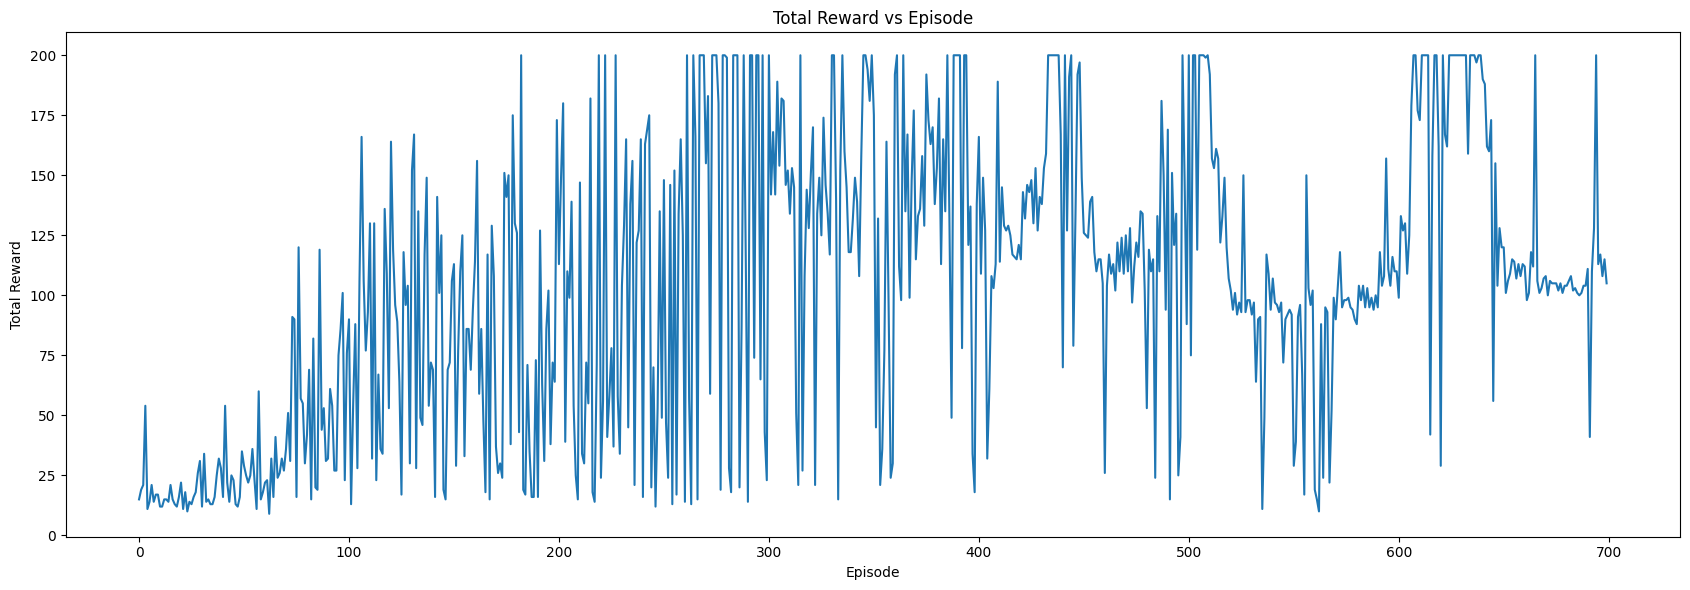

In [ ]:
plt.figure(figsize=(17, 6))
plt.plot(result['Total Reward'])
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward vs Episode')
plt.tight_layout()
plt.show()

<ipython-input-84-088d2893ea35>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = result.groupby('Bins')['Total Reward'].apply(list)


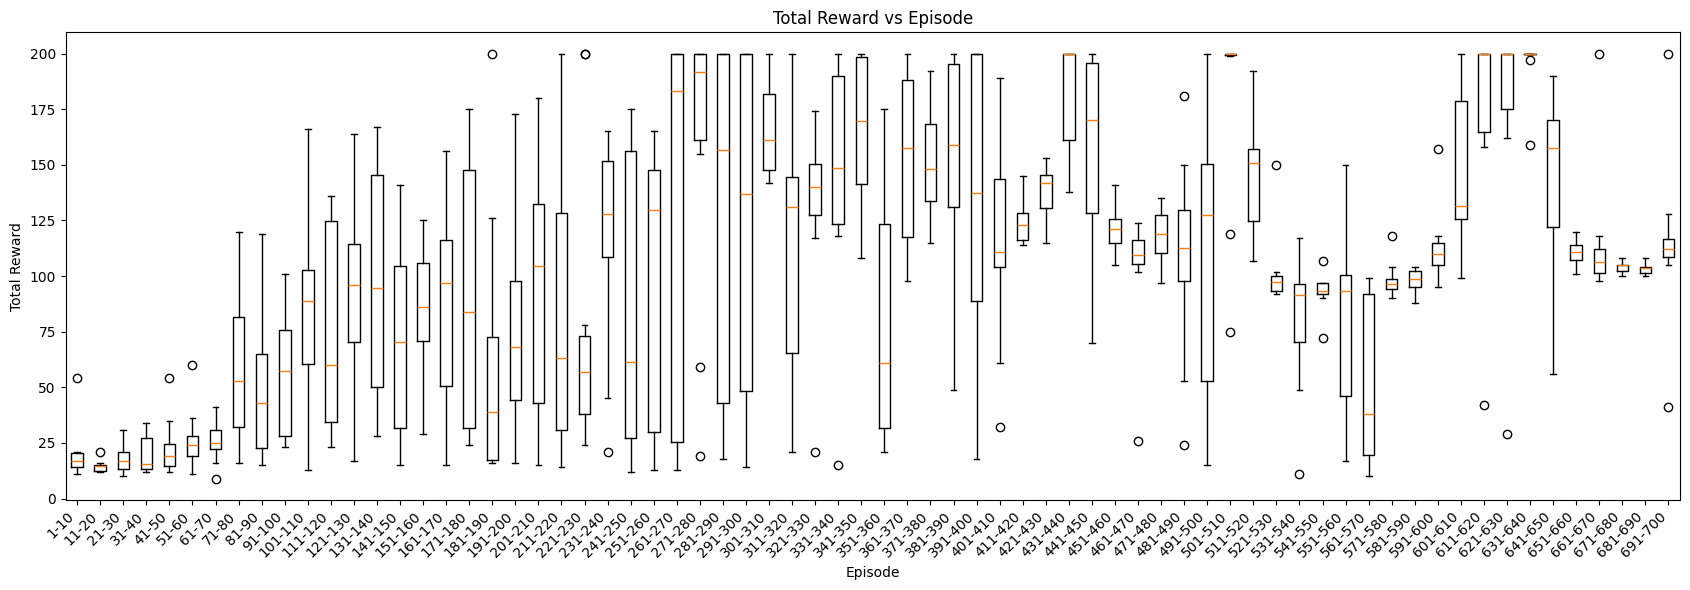

In [ ]:
grouped_data = result.groupby('Bins')['Total Reward'].apply(list)

bin_labels = grouped_data.index.tolist()

plt.figure(figsize=(17, 6))
plt.boxplot(grouped_data.values, labels=bin_labels)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward vs Episode')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

 Observations :-  
 * Its is evident that avarage reward per episode is increasing as algorithm get more experience.
 * The Reward was consistency is increased after  400 episodes.


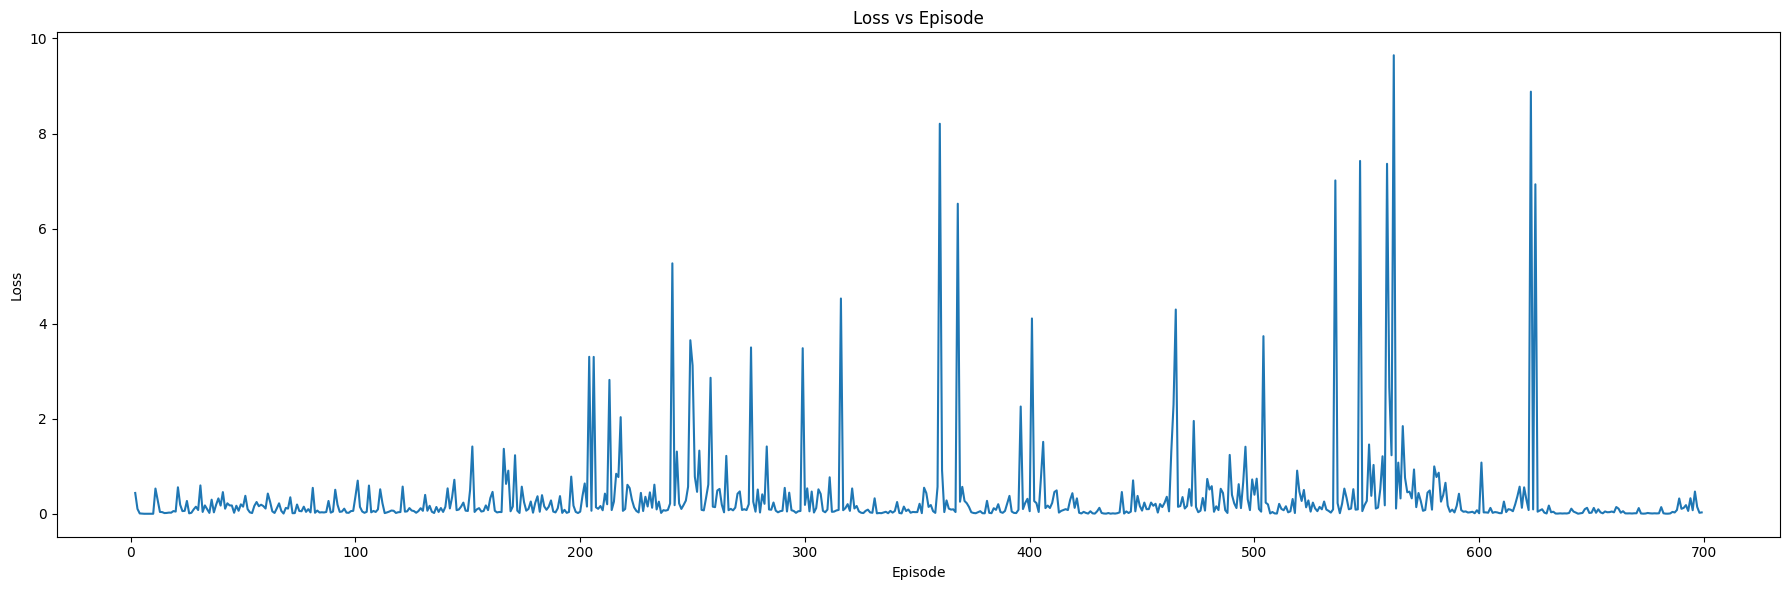

In [ ]:
plt.figure(figsize=(18, 6))
plt.plot(loss_vals)
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Loss vs Episode')
plt.tight_layout()
plt.show()

Observations : -
 *  The loss is decreasing consistently after 600 episodes although there are spikes we have in between  in the loss there might either that is completlety unseen or wrong prediction .

In [ ]:
test_result = pd.DataFrame(columns=['Episode', 'Total Reward', 'Epsilon'])

for episode in range(100):
    state = env.reset()
    total_reward = 0
    hist_flag = False

    for time_steps in range(n_steps):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        #agent.replay_buffer.add((state, action, reward, next_state, done))

        state = next_state
        total_reward += reward

        if done:
            break
    # Use .loc instead of .append to add a new row
    test_result.loc[len(test_result)] = {'Episode': episode, 'Total Reward': total_reward, 'Epsilon': agent.epsilon}

    print(f"Episode {episode+1}, Total Reward: {total_reward}, Epsilon: {agent.epsilon:.2f}")

env.close()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Episode 1, Total Reward: 107.0, Epsilon: 0.03
Episode 2, Total Reward: 109.0, Epsilon: 0.03
Episode 3, Total Reward: 105.0, Epsilon: 0.03
Episode 4, Total Reward: 102.0, Epsilon: 0.03
Episode 5, Total Reward: 109.0, Epsilon: 0.03
Episode 6, Total Reward: 104.0, Epsilon: 0.03
Episode 7, Total Reward: 105.0, Epsilon: 0.03
Episode 8, Total Reward: 44.0, Epsilon: 0.03
Episode 9, Total Reward: 105.0, Epsilon: 0.03
Episode 10, Total Reward: 100.0, Epsilon: 0.03
Episode 11, Total Reward: 107.0, Epsilon: 0.03
Episode 12, Total Reward: 114.0, Epsilon: 0.03
Episode 13, Total Reward: 105.0, Epsilon: 0.03
Episode 14, Total Reward: 105.0, Epsilon: 0.03
Episode 15, Total Reward: 110.0, Epsilon: 0.03
Episode 16, Total Reward: 109.0, Epsilon: 0.03
Episode 17, Total Reward: 103.0, Epsilon: 0.03
Episode 18, Total Reward: 107.0, Epsilon: 0.03
Episode 19, Total Reward: 102.0, Epsilon: 0.03
Episode 20, Total Reward: 110.0, Epsilon: 0.03
Episode 21, Total Reward: 101.0, Epsilon: 0.03
Episode 22, Total Rewar

#### Folllowing ones are zoomed versions  with 100 epochs

In [ ]:
bin_edges = np.arange(0, 110, 10)
bin_labels = [f"{i}-{i+9}" for i in range(1, 110, 10)][:len(bin_edges) - 1]

test_result['Bins'] = pd.cut(test_result['Episode'], bins=bin_edges, labels=bin_labels, include_lowest=True)

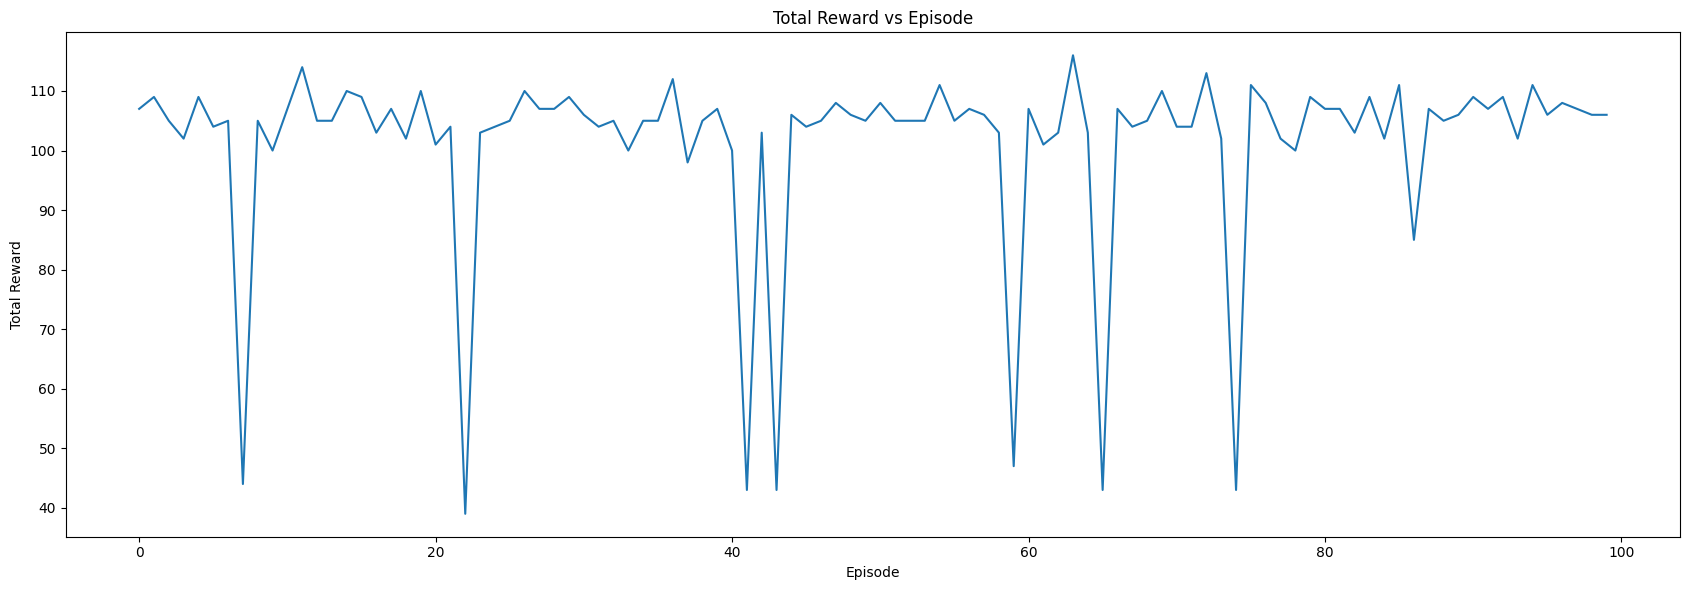

In [ ]:
plt.figure(figsize=(17, 6))
plt.plot(test_result['Total Reward'])
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward vs Episode')
plt.tight_layout()
plt.show()

<ipython-input-91-f0d9155651cc>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = test_result.groupby('Bins')['Total Reward'].apply(list)


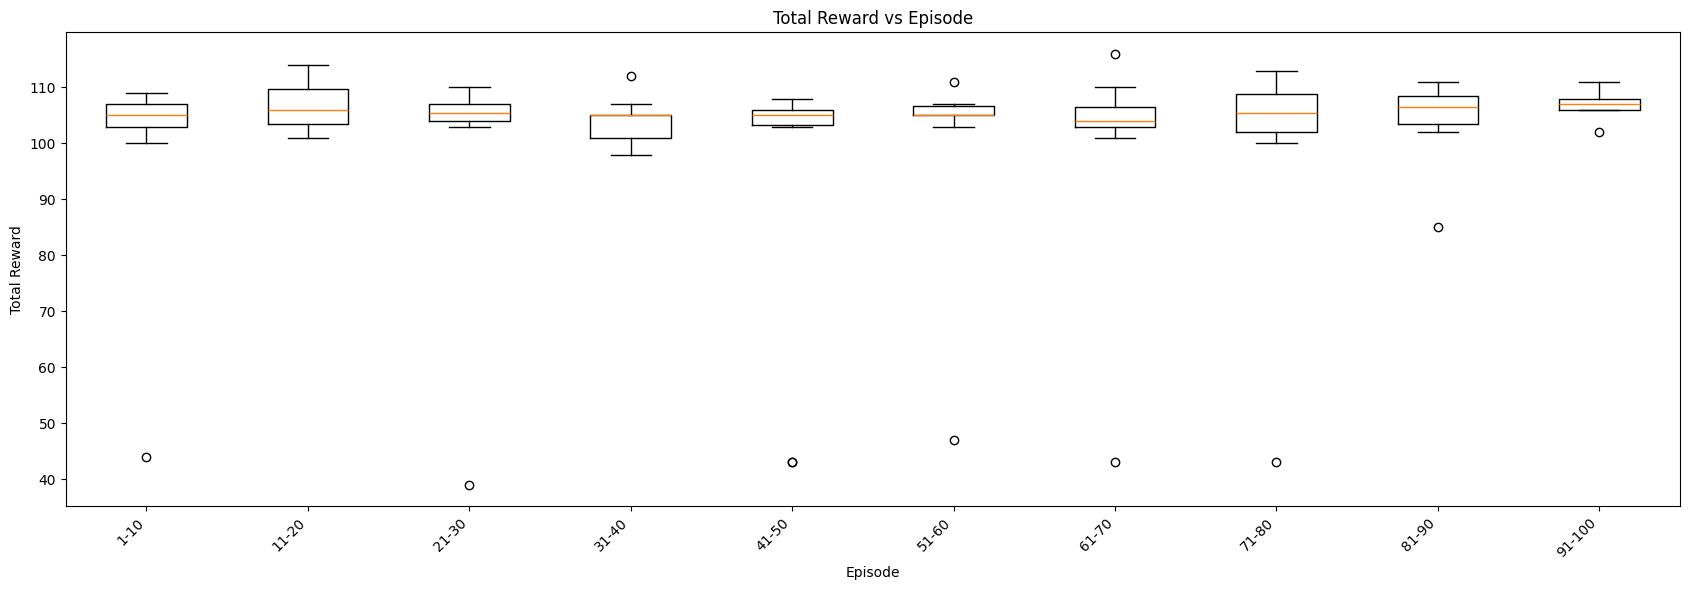

In [ ]:
grouped_data = test_result.groupby('Bins')['Total Reward'].apply(list)

bin_labels = grouped_data.index.tolist()

plt.figure(figsize=(17, 6))
plt.boxplot(grouped_data.values, labels=bin_labels)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward vs Episode')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# DQN Model
agent.policy_net.save(os.path.join(input_dir,'cartpole_dqn_model.h5'))